# DQN Implementation for CartPole environment

Reinforcement learning is a very interesting area which studies creation of self-educating agents, which can solve different tasks in   different environments. In this kernel I'm going to solve classic OpenAI Gym CartPole-v1 environment using Deep Q network algorithm. So let's start.

#### What is DQN?
DQN stands for Deep Q-Network, which is a type of reinforcement learning algorithm used in the field of artificial intelligence. 
DQN combines two key components: Q-learning and deep neural networks. Q-learning is a traditional reinforcement learning algorithm that learns an optimal action-value function called the Q-function. The Q-function represents the expected cumulative reward for taking a particular action in a given state.

Deep neural networks are used in DQN to approximate the Q-function. The network takes the current state as input and outputs the Q-values for all possible actions. By using a deep neural network, DQN is able to handle high-dimensional input spaces, such as images.

#### What is a Cartpole problem?
The CartPole problem is a classic benchmark problem in the field of reinforcement learning. It involves balancing a pole on a cart by moving the cart left or right. The goal is to keep the pole balanced for as long as possible.
In the CartPole problem, the environment consists of a cart that can move along a frictionless track, and a pole that is attached to the cart with a hinge. The cart can take two actions: move left or move right. The objective is to apply the appropriate actions to keep the pole balanced in an upright position.
The state of the CartPole problem is typically defined by four variables: the position and velocity of the cart, and the angle and angular velocity of the pole. These variables describe the current state of the system and are used to make decisions about the next action to take.

## Import required libraries

In [2]:
import json
import random
import time
from collections import deque
from IPython.display import display, Image

import gym
import keras
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Environment — CartPole-v1
The simulation environment to be used will be the gym CartPole environment, which consists of a cart that moves along a horizontal guide with a vertical pole mounted on it, as shown in Figure 1. The objective is that, by means of the inertia generated by the cart in its horizontal displacements, the pole remains vertical as long as possible. An episode is considered successful when the pole remains vertical for more than 500 timesteps, and an episode is considered unsuccessful if the cart runs off the horizontal guide on the right or left side, or if the pole tilts more than 12 degrees (~0.2095 radians) with respect to the vertical axis.

In [3]:
Image(url='https://miro.medium.com/v2/resize:fit:640/format:webp/1*t9VQECZu7X3sIIwMRndQ_Q.png')

(Figure 1. Image of the CartPole environment.)
Image extracted from the rendering of the gym environment
The environment has a discrete action space, since the DQN algorithm is not applicable to environments with a continuous action space, and the state space is continuous, because the main advantage of DQN over Q-Learning is the possibility of working with continuous or high-dimensional states, which is to be proved.

## Actions

* 0 [Action number]       - push cart left [Action]
* 1 [Action number]       - push cart right [Action]

## States
The states are represented as an array of 4 elements, where the meaning of each element, as well as their allowed value ranges are:

In [4]:
Image(url='https://miro.medium.com/v2/resize:fit:640/format:webp/1*abT4yGli9A-ejrLycAO9UA.png')

(Figure 2. States for the CartPole environment.)
It should be noted that, although the allowed value ranges are those shown in the table, an episode will be terminated if:

The Cart position on the x axis leaves the (-2.4, 2.4) range
The Pole angle leaves the (-0.2095, 0.2095) range

## Rewards
The agent receives a reward of +1 for each time step, with the intention of keeping the pole standing for as long as possible.

## Define DQNAgent Class

In [5]:
class DQNAgent:
    
    def __init__(self, state_size, action_size):

        self.state_size = state_size
        self.action_size = action_size
        
        # Initialize Replay Buffer as python deque
        self.replay_buffer = deque(maxlen=100000)
        
        # Set algorithm hyperparameters
        self.gamma = 0.99
        self.epsilon = 1.
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.98
        self.learning_rate = 0.001
        self.update_rate = 10
        
        # Create both Main and Target Networks
        self.main_network = self.create_nn()
        self.target_network = self.create_nn()
        
        # Initialize Target Network with Main Network's weights
        self.update_target_network()

    def create_nn(self):
        
        model = Sequential()

        model.add(Dense(64, activation='relu', input_dim=self.state_size))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))

        return model
    
    def update_target_network(self):
        # Method to set the Main NN's weights on the Target NN
        self.target_network.set_weights(self.main_network.get_weights())

    def save_experience(self, state, action, reward, next_state, terminal):
        
        # Save the given experience as a (s, a, r, s', terminal) tuple
        self.replay_buffer.append((state, action, reward, next_state, terminal))

    def sample_experience_batch(self, batch_size):
        
        # Sample {batchsize} experiences from the ReplayBuffer
        exp_batch = random.sample(self.replay_buffer, batch_size)

        # Create an array with the {batchsize} elements for s, a, r, s' and terminal information
        state_batch = np.array([batch[0] for batch in exp_batch]).reshape(batch_size, self.state_size)
        action_batch = np.array([batch[1] for batch in exp_batch])
        reward_batch = [batch[2] for batch in exp_batch]
        next_state_batch = np.array([batch[3] for batch in exp_batch]).reshape(batch_size, self.state_size)
        terminal_batch = [batch[4] for batch in exp_batch]

        # Return a tuple, where each item corresponds to each array/batch created above
        return state_batch, action_batch, reward_batch, next_state_batch, terminal_batch

    def pick_epsilon_greedy_action(self, state):

        # Pick random action with probability ε
        if random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.action_size)

        # Pick action with highest Q-Value (item with highest value for Main NN's output)
        state = state.reshape((1, self.state_size))
        q_values = self.main_network.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def train(self, batch_size):

        # Sample a batch of experiences
        state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = self.sample_experience_batch(batch_size)

        # Get the actions with highest Q-Value for the batch of next states
        next_q = self.target_network.predict(next_state_batch, verbose=0)
        max_next_q = np.amax(next_q, axis=1)
        # Get the Q-values of each state in the batch of states
        q_values = self.main_network.predict(state_batch, verbose=0)

        # Update the Q-Value corresponding to the current action with the Target Value
        for i in range(batch_size):
            q_values[i][action_batch[i]] = reward_batch[i] if terminal_batch[i] else reward_batch[i] + self.gamma * max_next_q[i]

        # Fit the network
        self.main_network.fit(state_batch, q_values, verbose=0)


## Implement flow for DQN algorithm

### 1. Initialize Gym Environment

In [6]:
# Initialize CartPole environment
env = gym.make('CartPole-v1')

# Define state and action size
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### 2. Define number of episodes, timesteps per episode and batch size

In [7]:
num_episodes = 150
num_timesteps = 500
batch_size = 64

### 3. Initlaize DQNAgent

In [8]:
dqn_agent = DQNAgent(state_size, action_size)

### 4. Implement and execute flow of DQN algorithm

In [10]:
rewards, epsilon_values = list(), list() # Lists to keep logs of rewards and apsilon values, for plotting later
time_step = 0 # Initalize timestep counter

for ep in range(num_episodes):
    
    tot_reward = 0
    state, _ = env.reset()
    
    print(f'\nTraining on EPISODE {ep+1} with epsilon {dqn_agent.epsilon}')
    start = time.time()
    
    for t in range(num_timesteps):
        
        time_step += 1
        
        # Update Target Network every {dqn_agent.update_rate} timesteps
        if time_step % dqn_agent.update_rate == 0:
            dqn_agent.update_target_network()
            
        action = dqn_agent.pick_epsilon_greedy_action(state) # Select action with ε-greedy policy
        next_state, reward, terminal, _, _ = env.step(action) # Perform action on environment
        dqn_agent.save_experience(state, action, reward, next_state, terminal) # Save experience in ReplayBuffer

        state = next_state
        tot_reward += reward

        if terminal:
            print('Episode: ', ep+1, ' terminated with Reward ', tot_reward)
            break

        # Train the Main Network when ReplayBuffer has enough experiences to fill a batch
        if len(dqn_agent.replay_buffer) > batch_size:
            dqn_agent.train(batch_size)

    rewards.append(tot_reward)
    epsilon_values.append(dqn_agent.epsilon)
    
    # Everytime an episode is finished, update Epsilon value to a lower value
    if dqn_agent.epsilon > dqn_agent.epsilon_min:
        dqn_agent.epsilon *= dqn_agent.epsilon_decay
        
    # Print information about the Episode performed
    elapsed = time.time() - start
    print(f'Time elapsed during EPISODE {ep+1}: {elapsed} seconds = {round(elapsed/60, 3)} minutes')

    # If the agent got a reward >499 in each of the last 10 episodes, the training is terminated
    if sum(rewards[-10:]) > 4990:
        print('Training stopped because agent has performed a perfect episode in the last 10 episodes')
        break        


Training on EPISODE 1 with epsilon 0.9411919999999999
Episode:  1  terminated with Reward  19.0
Time elapsed during EPISODE 1: 3.451523542404175 seconds = 0.058 minutes

Training on EPISODE 2 with epsilon 0.9223681599999999
Episode:  2  terminated with Reward  14.0
Time elapsed during EPISODE 2: 2.4847352504730225 seconds = 0.041 minutes

Training on EPISODE 3 with epsilon 0.9039207967999998
Episode:  3  terminated with Reward  15.0
Time elapsed during EPISODE 3: 2.96059513092041 seconds = 0.049 minutes

Training on EPISODE 4 with epsilon 0.8858423808639998
Episode:  4  terminated with Reward  13.0
Time elapsed during EPISODE 4: 2.469325304031372 seconds = 0.041 minutes

Training on EPISODE 5 with epsilon 0.8681255332467198
Episode:  5  terminated with Reward  9.0
Time elapsed during EPISODE 5: 2.2236037254333496 seconds = 0.037 minutes

Training on EPISODE 6 with epsilon 0.8507630225817854
Episode:  6  terminated with Reward  23.0
Time elapsed during EPISODE 6: 4.452521800994873 seco

### 5. Test the trained by executing an episode

In [11]:
def select_trained_agent_action(state, trained_model):
    q_values = trained_model.predict(state, verbose=0)
    return np.argmax(q_values[0])

In [12]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
state, _ = env.reset()
state_size = env.observation_space.shape[0]
total_reward = 0
max_timesteps = 500

# Execute episode
for t in range(max_timesteps):
    print(f'Running frame {t+1}...', end='\r')
    
    state = state.reshape((1, state_size))
    action = select_trained_agent_action(state, dqn_agent.main_network)
    next_state, reward, terminal, _, _ = env.step(action)
    
    total_reward += reward
    state = next_state
    
env.close()
    
print(f'Test episode terminated with reward {total_reward} (Max Reward=500)')


Test episode terminated with reward 500.0 (Max Reward=500)


### 6. Plot mean rewards of the agent 

In [13]:
import matplotlib.pyplot as plt

In [14]:
def plot_rewards(mean_range=1):
    
    # The parameter mean_range must allow equal separation of rewards
    if len(rewards) % mean_range != 0:
        raise ValueError
        
    # Calculate mean rewards
    mean_rewards = list()
    for i in range(round(len(rewards)/mean_range)):
        reward_on_range = rewards[i*mean_range:i*mean_range+mean_range]
        reward_on_range_mean = round(sum(reward_on_range)/len(reward_on_range))
        mean_rewards.append(reward_on_range_mean)
        
    plt.plot(range(len(mean_rewards)), mean_rewards)
    plt.show()

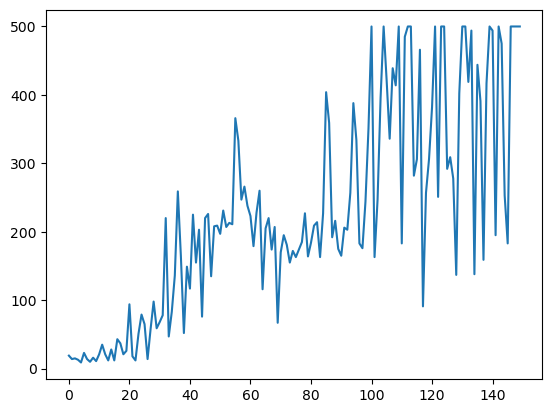

In [15]:
plot_rewards()

### 7. Plot values of epsilon during the training

In [16]:
def plot_epsilon_values():
    
    plt.plot(range(len(epsilon_values)), epsilon_values)
    plt.show()

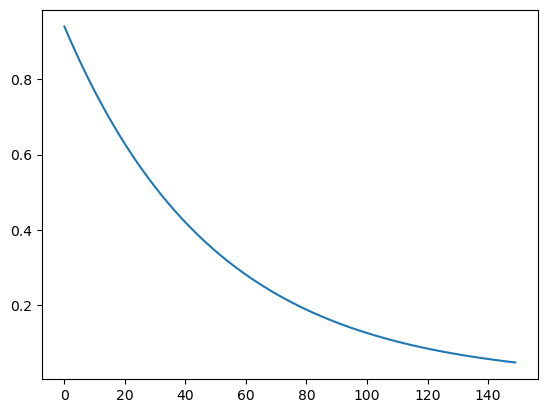

In [17]:
plot_epsilon_values()

## Conclusion

In conclusion, the application of the Deep Q-Network (DQN) algorithm to the CartPole problem has been successful and has provided valuable insights into reinforcement learning. The CartPole problem involves balancing a pole on a cart by making appropriate movements. DQN, a combination of Q-learning and deep neural networks, has proven to be an effective approach for learning an optimal policy in this environment.

Reference:
https://towardsdatascience.com/applied-reinforcement-learning-iv-implementation-of-dqn-7a9cb2c12f97